<a href="https://colab.research.google.com/github/gmit22/LifeHack-2020/blob/master/Image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.utils import shuffle
import imutils
import pandas as pd

In [3]:
dir = os.path.join(os.getcwd(), "drive/My Drive/data")

In [4]:
def loadData(dir):

    images = []
    category = []
    file_dir = []

    for img in os.listdir(dir):

        if img.endswith(".png"):
        #images.append(cv2.imread(os.path.join(dir, img)))
            file_dir.append(os.path.join(dir, img))

            if img.startswith('NL'):      #assigning label to file according to          
                category.append(0)             # their type

            elif img.startswith('ca'):    
                category.append(1)

            elif img.startswith('Gl'):  
                category.append(2)

            elif img.startswith('Re'):          
                category.append(3)

    file_dir = np.array(file_dir)
    category = np.array(category, dtype = 'int32')  

    return shuffle(file_dir, category,random_state=862)


In [5]:
file_dir, category = loadData(dir)

In [6]:
print(len(file_dir))

601


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
def get_label(encoded_val):
      
      labels = {0:'normal', 1:'cataract', 2:'glaucoma', 3:'retina'}
      return labels[encoded_val]

In [9]:
def data_augment(file_dir, labels):

    img_set = []
    lbl_set = []

    for i in range(len(file_dir)):

        if i%100==0:
            print(i)
        label = labels[i]
        img = get_object(file_dir[i])

        img_b = img + 0.07*img
        img_d = img - 0.07*img

        flip_v_b = cv2.flip(img_b,0)
        flip_h_b = cv2.flip(img_b,1)

        flip_v_d = cv2.flip(img_d,0)
        flip_h_d = cv2.flip(img_d,1)

        flip_v = cv2.flip(img,0) #vertical flip
        flip_h = cv2.flip(img,1) #lr flip

        img_set.append(img)
        # img_set.append(img_b)
        # img_set.append(img_d)
        img_set.append(flip_v)
        img_set.append(flip_h)
        img_set.append(flip_v_b)
        img_set.append(flip_h_b)
        img_set.append(flip_v_d)
        img_set.append(flip_h_d)

        # lbl_set.append(label)
        # lbl_set.append(label)
        lbl_set.append(label)
        lbl_set.append(label)
        lbl_set.append(label)
        lbl_set.append(label)
        lbl_set.append(label)
        lbl_set.append(label)
        lbl_set.append(label)
    print('Done')
    return np.array(img_set),np.array(lbl_set)


In [10]:
def get_object(filename):

    image = cv2.imread(filename)
    im_size = 256
    
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) # convert 2 grayscale

    retval, threshold = cv2.threshold(gray,10,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(threshold,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) # find contours

    # ensure at least some circles were found
    if contours:

        contours = sorted(contours, key=cv2.contourArea, reverse=True) 

        #find the bounding rect
        x,y,w,h = cv2.boundingRect(contours[0])                  
        img = image[y:y+h,x:x+w]# crop image

        resize=cv2.resize(img,(im_size,im_size)) # resize to im_size X im_size size
        
        return resize

    return cv2.resize(image, (im_size,im_size))

In [11]:
X, y = data_augment(file_dir, category)

0
100
200
300
400
500
600
Done


CNN model

In [12]:
import keras
y_encoded = keras.utils.to_categorical(y, 4)
X = X.astype('float32')
X /= 255

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


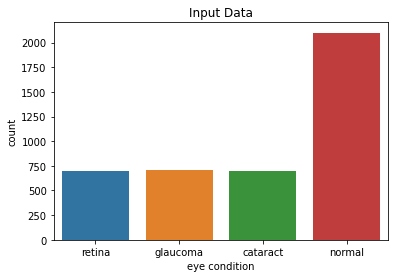

In [13]:
import seaborn as sns
data = pd.DataFrame(
    data=(get_label(y[i]) for i in range(0, len(y))),    # values
    columns=['eye condition']
) 

input = sns.countplot(
    data=data,
    x = 'eye condition',
    order = ['retina', 'glaucoma', 'cataract', 'normal']
).set_title('Input Data')

plt.savefig('Input Dataset')

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=5)

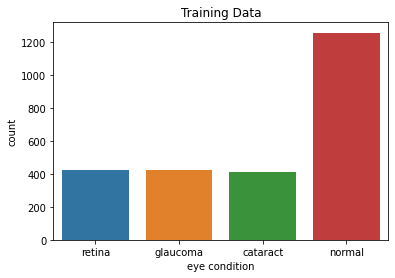

In [19]:
Y_train = np.argmax(y_train,axis = 1)
data = pd.DataFrame(
    data=(get_label(Y_train[i]) for i in range(0, len(Y_train))),    # values
    columns=['eye condition']
) 

training = sns.countplot(
    data=data,
    x = 'eye condition',
    order = ['retina', 'glaucoma', 'cataract', 'normal']
).set_title('Training Data')

plt.savefig('Training Data')

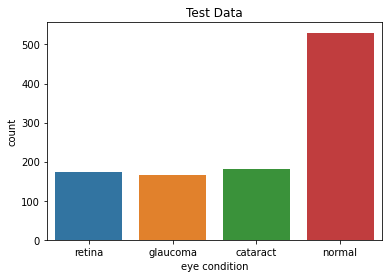

In [20]:
Y_test = np.argmax(y_test,axis = 1)
data = pd.DataFrame(
    data=(get_label(Y_test[i]) for i in range(0, len(Y_test))),    # values
    columns=['eye condition']
) 

training = sns.countplot(
    data=data,
    x = 'eye condition',
    order = ['retina', 'glaucoma', 'cataract', 'normal']
).set_title('Test Data')
plt.savefig('Test Data')

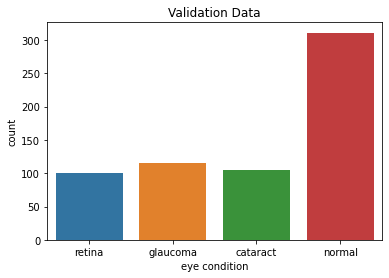

In [17]:
Y_val = np.argmax(y_val,axis = 1)
data = pd.DataFrame(
    data=(get_label(Y_val[i]) for i in range(0, len(Y_val))),    # values
    columns=['eye condition']
) 

val = sns.countplot(
    data=data,
    x = 'eye condition',
    order = ['retina', 'glaucoma', 'cataract', 'normal']
).set_title('Validation Data')

plt.savefig('Validation Data')

In [21]:
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras

To visualize results

In [22]:
def visualize_results(history):

    # Plot the accuracy and loss curves
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    
    plt.title('Training and validation loss')
    
    plt.legend()
    plt.show()
    plt.savefig(f'{history}.png')

Creating model using Keras

In [23]:
trained_models = []

Model 1

In [24]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

Model 2


In [25]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model_2 = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_2.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.summary()
# train the model on the new data for a few epochs
trained_model_1 = model_2.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=30, #number of iterations
    validation_data=(X_val, y_val),
    shuffle=True
)

87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/30
79/79 [==============================] - 24s 304ms/step - loss: 1.7048 - accuracy: 0.5139 - val_loss: 0.9702 - val_accuracy: 0.6117
Epoch 2/30
79/79 [==============================] - 20s 253ms/step - loss: 0.9989 - accuracy: 0.5951 - val_loss: 0.9354 - val_accuracy: 0.6212
Epoch 3/30
79/79 [==============================] - 20s 259ms/step - loss: 0.8961 - accuracy: 0.6331 - val_loss: 0.9413 - val_accuracy: 0.6244
Epoch 4/30
79/79 [==============================] - 20s 253ms/step - loss: 0.8325 - accuracy: 0.6525 - val_loss: 0.7844 - val_accuracy: 0.6545
Epoch 5/30
79/79 [==============================] - 20s 254ms/step - loss: 0.7761 - accuracy: 0.6767 - val_loss: 0.7199 - val_accuracy: 0.7036
Epoch 6/30
79/79 [==============================] - 20s 250ms/step - loss: 0.7112 - accuracy: 0.7084 - val_loss: 0.8825 - val_accuracy: 0.6751
Epoch 7/30
79/79 [==============================] - 20s 252ms/step - loss: 0.

33/33 [==============================] - 7s 199ms/step - loss: 0.2327 - accuracy: 0.9430
The model accuracy is 0.9429658055305481


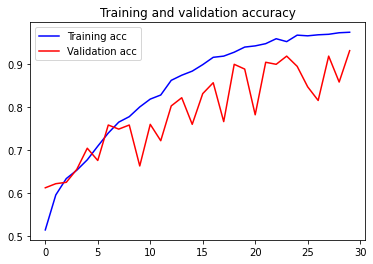

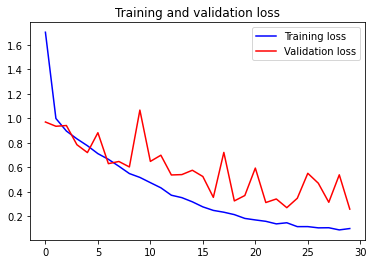

<Figure size 432x288 with 0 Axes>

In [26]:
_, accuracy = model_2.evaluate(X_test, y_test)
print(f'The model accuracy is {accuracy}')
visualize_results(trained_model_1)

[[515   5   7   3]
 [  2 179   1   0]
 [ 16   3 141   6]
 [ 14   3   0 157]]


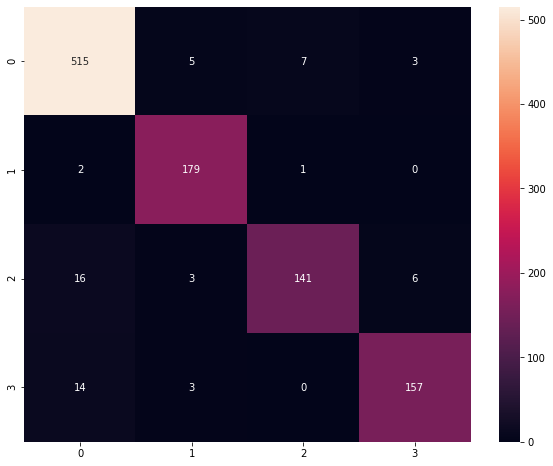

In [27]:
from sklearn.metrics import confusion_matrix
prediction = model_2.predict(X_test)
Y_pred_classes = np.argmax(prediction,axis = 1)

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

print(confusion_mtx)

import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d")
plt.savefig("trained_model_1_cm.png")

Model 3

In [31]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(4, activation='softmax')(x)

model_3 = Model(inputs=base_model.input, outputs=predictions)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_3.layers[:249]:
   layer.trainable = False
for layer in model_3.layers[249:]:
   layer.trainable = True


# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model_3.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

trained_model_2 = model_3.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=25, #number of iterations
    validation_data=(X_val, y_val),
    shuffle=True
)

Epoch 1/25
79/79 [==============================] - 25s 320ms/step - loss: 1.2036 - accuracy: 0.4853 - val_loss: 1.1743 - val_accuracy: 0.5087
Epoch 2/25
79/79 [==============================] - 24s 302ms/step - loss: 1.0377 - accuracy: 0.5717 - val_loss: 1.0342 - val_accuracy: 0.5642
Epoch 3/25
79/79 [==============================] - 24s 301ms/step - loss: 0.9379 - accuracy: 0.6082 - val_loss: 0.9347 - val_accuracy: 0.6260
Epoch 4/25
79/79 [==============================] - 24s 304ms/step - loss: 0.8567 - accuracy: 0.6513 - val_loss: 0.8651 - val_accuracy: 0.6529
Epoch 5/25
79/79 [==============================] - 24s 304ms/step - loss: 0.7842 - accuracy: 0.6870 - val_loss: 0.8101 - val_accuracy: 0.6815
Epoch 6/25
79/79 [==============================] - 24s 304ms/step - loss: 0.7242 - accuracy: 0.7302 - val_loss: 0.7607 - val_accuracy: 0.7116
Epoch 7/25
79/79 [==============================] - 23s 296ms/step - loss: 0.6638 - accuracy: 0.7559 - val_loss: 0.7141 - val_accuracy: 0.7512

In [32]:
prediction = model_3.predict(X_test)

Predict classes, and check actual values

33/33 [==============================] - 6s 195ms/step - loss: 0.2783 - accuracy: 0.9154
The model accuracy is 0.9153992533683777


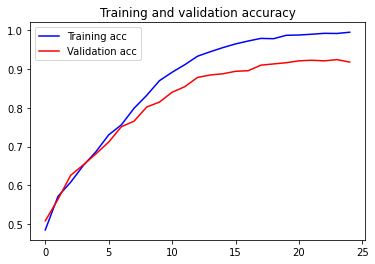

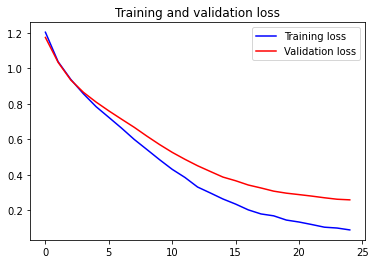

<Figure size 432x288 with 0 Axes>

In [33]:
_, accuracy = model_3.evaluate(X_test, y_test)
print(f'The model accuracy is {accuracy}')
visualize_results(trained_model_2)

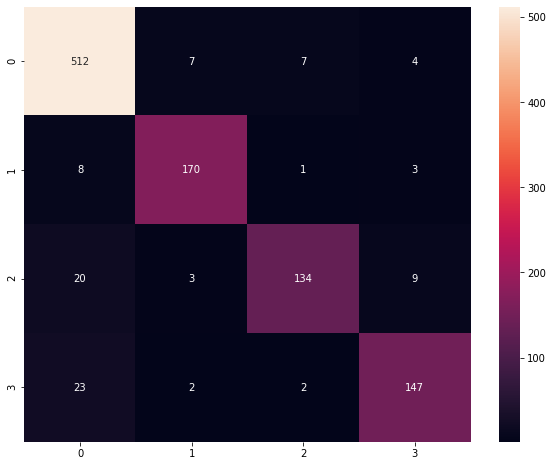

In [34]:
from sklearn.metrics import confusion_matrix
Y_pred_classes = np.argmax(prediction,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d")

    Model 4

In [49]:
import math
from tensorflow.keras import optimizers
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(4, activation='softmax')(x)

model_4 = Model(inputs=base_model.input, outputs=predictions)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_4.layers[:249]:
   layer.trainable = False
for layer in model_4.layers[249:]:
   layer.trainable = True

lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = optimizers.SGD(learning_rate=lr_schedule)

# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model_4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

trained_model_3 = model_4.fit(
    X_train,
    y_train,
    batch_size=32,
    steps_per_epoch=72,
    epochs=6, #number of iterations
    validation_data=(X_val, y_val),
    shuffle=True
)


Epoch 1/6
72/72 [==============================] - 23s 326ms/step - loss: 0.9096 - accuracy: 0.6445 - val_loss: 1.0729 - val_accuracy: 0.5578
Epoch 2/6
72/72 [==============================] - 22s 305ms/step - loss: 0.4547 - accuracy: 0.8557 - val_loss: 0.6749 - val_accuracy: 0.7464
Epoch 3/6
72/72 [==============================] - 22s 305ms/step - loss: 0.1971 - accuracy: 0.9591 - val_loss: 0.3211 - val_accuracy: 0.9081
Epoch 4/6
72/72 [==============================] - 22s 305ms/step - loss: 0.0816 - accuracy: 0.9904 - val_loss: 0.2414 - val_accuracy: 0.9271
Epoch 5/6
72/72 [==============================] - 22s 304ms/step - loss: 0.0375 - accuracy: 0.9974 - val_loss: 0.2127 - val_accuracy: 0.9382
Epoch 6/6
72/72 [==============================] - 22s 305ms/step - loss: 0.0218 - accuracy: 0.9991 - val_loss: 0.1974 - val_accuracy: 0.9350


In [50]:
prediction = model_4.predict(X_test)

33/33 [==============================] - 6s 196ms/step - loss: 0.2783 - accuracy: 0.9154
The model accuracy is 0.9153992533683777


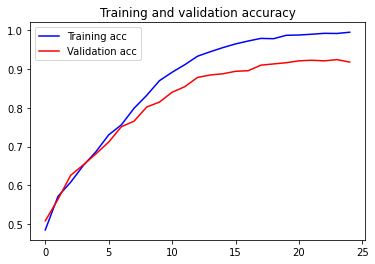

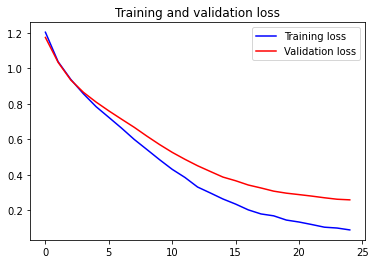

<Figure size 432x288 with 0 Axes>

In [51]:
_, accuracy = model_3.evaluate(X_test, y_test)
print(f'The model accuracy is {accuracy}')
visualize_results(trained_model_2)

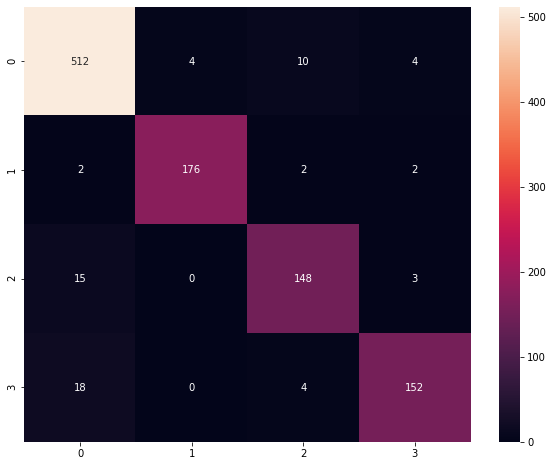

In [52]:
from sklearn.metrics import confusion_matrix
Y_pred_classes = np.argmax(prediction,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d")